In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !unzip "/content/CBSD68-dataset-master.zip"

In [0]:
import pandas as pd
import os
import random
random.seed(2)

files = os.listdir("/content/CBSD68-dataset-master/CBSD68/original_png")
# files = [file[:-4] for file in files if "real" in file]

random.shuffle(files)

train = files[:50]
val = files[50:59]
test = files[59:]

# print(len(files))

train_df = pd.DataFrame({"files":train})
train_df.to_csv("/content/train_data.csv",index=None)

val_df = pd.DataFrame({"files":val})
val_df.to_csv("/content/val_data.csv",index=None)

test_df = pd.DataFrame({"files":test})
test_df.to_csv("/content/test_data.csv",index=None)

In [161]:
test_df

,files
0,0064.png
1,0045.png
2,0055.png
3,0003.png
4,0041.png
5,0047.png
6,0030.png
7,0028.png
8,0011.png


In [0]:
# Project: ML 7641
# Author: Sai Sateesh Gudapati

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from skimage import io, transform
from skimage.color import rgb2ycbcr
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import pickle
import PIL

%matplotlib inline

plt.ion()   # interactive mode

device = torch.device('cuda')

In [0]:
## Define transforms

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, n_image = sample['original_image'], sample['noisy_image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w,1))
        n_img = transform.resize(n_image,(new_h, new_w,1))
        
#         print(img.shape)

        return {'noisy_image': n_img, 'original_image': img}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, n_image = sample['original_image'], sample['noisy_image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        # new_h, new_w = h,w

        # print(h,new_h)

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        # top =0
        # left =0

        n_image = n_image[top: top + new_h,
                      left: left + new_w]

        # image = image[top: top + new_h,
                      # left: left + new_w]

        image = image[top+8: top + new_h-8,
                      left+8: left + new_w-8]



        s = self.output_size[0]
        # image = transform.resize(image, (s, s,1))
        # n_image = transform.resize(n_image,(s, s,1))

        return {'original_image': image, 'noisy_image': n_image}



class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, n_image = sample['original_image'], sample['noisy_image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        n_image = n_image.transpose((2, 0, 1))
        return {'original_image': torch.from_numpy(image),
                'noisy_image': torch.from_numpy(n_image)}


# scale = Rescale((400,400))
# to_tensor = ToTensor()
composed = transforms.Compose([RandomCrop(33),ToTensor()])
# composed = transforms.Compose([ToTensor()])

# ## transforms
# composed = transforms.Compose([transforms.RandomCrop(33),
#                                transforms.RandomHorizontalFlip(),
#                                transforms.RandomVerticalFlip(),
#                                transforms.RandomRotation(90),
#                                transforms.RandomRotation(180),
#                                transforms.RandomRotation(270),
#                                transforms.ToTensor()])

In [0]:
class NoisyImageDataset(Dataset):
    """Using PASCAL VOC dataset to create Y,X samples."""

    def __init__(self, csv_file, root_dir, transform=composed):
        """
        Args:
            csv_file (string): Path to the csv file with image names.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_data = pd.read_csv(csv_file)
        # print(self.image_data)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir+"/original_png",
                                self.image_data.iloc[idx, 0])
        
        n_img_name = os.path.join(self.root_dir+"/noisy25",
                                self.image_data.iloc[idx, 0])
        
        image = io.imread(img_name)
        # image = rgb2ycbcr(image)
        image = image.astype("float64")

        noisy_image = io.imread(n_img_name)
        noisy_image = noisy_image.astype("float64")
        
        # print(noisy_image[:,:,0].shape)
        # sample = {'noisy_image': noisy_image2, 'original_image': noisy_image}
        sample = {'noisy_image': noisy_image, 'original_image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [232]:
noise_dataset = NoisyImageDataset("/content/train_data.csv","/content/CBSD68-dataset-master/CBSD68")

val_dataset = NoisyImageDataset("/content/val_data.csv","/content/CBSD68-dataset-master/CBSD68")

o,n = noise_dataset[6].values()
print(n.shape,o.shape)

torch.Size([3, 33, 33]) torch.Size([3, 17, 17])


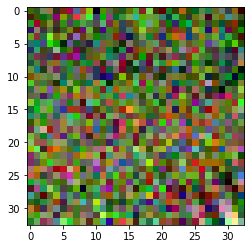

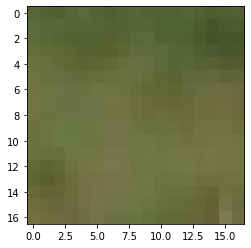

In [233]:
## visualize crop transform

# Apply each of the above transforms on sample.
# fig = plt.figure()

# crop = RandomCrop(256)
sample = noise_dataset[10]

plt.imshow(sample["noisy_image"].numpy().astype("uint8").transpose((1,2,0)))
plt.show()

plt.imshow(sample["original_image"].numpy().astype("uint8").transpose((1,2,0)))
plt.show()

In [0]:
## create dataloader

dataloader = DataLoader(noise_dataset, batch_size=16,
                        shuffle=True, num_workers=4)

valloader = DataLoader(val_dataset, batch_size=4,
                        shuffle=True, num_workers=2)

In [0]:
## Defining 3 layer DN-Resnet 

class DNNet(nn.Module):
    def __init__(self):
        super(DNNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=0),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=0),
            nn.ReLU())

    ## forward pass
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [0]:
## Output of the code
class DNNet_res(nn.Module):
    def __init__(self):
        super(DNNet_res, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=0),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=0),
            nn.ReLU())
        self.res_layer1 = nn.Sequential(nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        # nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.res_layer2 = nn.Sequential(nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1))
        self.rel_layer = nn.Sequential(nn.ReLU())

    ## forward pass
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        res1 = self.res_layer1(out)
        res2 = self.res_layer2(res1)
        out = self.rel_layer(out+res2)
        res3 = self.res_layer1(out)
        res4 = self.res_layer2(res3)
        out = self.rel_layer(out+res4)
        res5 = self.res_layer1(out)
        res6 = self.res_layer2(res5)
        out = self.rel_layer(out+res6)
        out = self.layer3(out)
        return out

In [0]:
## define model

model = DNNet()
model = model.double()
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
## resned model
model2 = DNNet_res()
model2 = model2.double()
model2.to(device)

# model_dict = model2.state_dict()
# model_dict.update(model.state_dict())
# model2.load_state_dict(model_dict)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)

In [228]:
model_weights = torch.load("/content/drive/My Drive/dn_resnet_200.pt")
model2.load_state_dict(model_weights)

<All keys matched successfully>

In [236]:
import time
# Train the model
total_step = len(dataloader)
step_loss_list = []
train_loss_list = []
val_loss_list = []
num_epochs = 1000

training_start_time = time.time()

for epoch in range(num_epochs):
    train_loss = 0
    for i, batch in enumerate(dataloader):
        step_start_time = time.time()
        # Run the forward pass
        images = batch['noisy_image'].to(device)
        labels = batch['original_image'].to(device)
        outputs = model2(images)
        # print(outputs.shape,labels.shape)
        loss = criterion(outputs, labels)
        step_loss_list.append(loss.item())
        train_loss+=loss.item()

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # time_per_step = time.time() - step_start_time

        # if (i + 1) % 10 == 0:
          # print(i)
            # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Time_per_step: {:.2f}s'
                  # .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),time_per_step))

    # print("Training loss = {:.2f} at Epoch {}".format(train_loss / total_step,epoch+1))
    
    train_loss_list.append(train_loss)
    #At the end of the epoch, do a pass on the validation set
    total_val_loss = 0
    for i, batch in enumerate(valloader):
        images = batch['noisy_image'].to(device)
        labels = batch['original_image'].to(device)
        # #Wrap tensors in Variables
        # inputs, labels = Variable(inputs), Variable(labels)
        
        #Forward pass
        val_outputs = model2(images)
        val_loss = criterion(val_outputs, labels)
        total_val_loss += val_loss.item()
    
    val_loss_list.append(total_val_loss)
    print("Training loss = {:.4f} || Validation loss = {:.4f} at Epoch {}".format(train_loss / total_step,total_val_loss / len(valloader),epoch+1))

    if (epoch+1)%50 == 0:
      # torch.save(model.state_dict(), "/content/drive/My Drive/nac_bsd_dn_resnet_{}.pt".format(epoch+1))
      loss_dict = {"train_loss":train_loss_list,"val_loss":val_loss_list}
      # output = open('/content/drive/My Drive/nac_bsd_dn_resnet_{}.pkl'.format(epoch+1), 'wb')
      # pickle.dump(loss_dict, output)
      # output.close()  

print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

Training loss = 214.3865 || Validation loss = 279.4498 at Epoch 1
Training loss = 182.8965 || Validation loss = 299.6533 at Epoch 2
Training loss = 192.2260 || Validation loss = 219.7187 at Epoch 3
Training loss = 158.8138 || Validation loss = 265.1544 at Epoch 4
Training loss = 177.1780 || Validation loss = 258.6014 at Epoch 5
Training loss = 173.3164 || Validation loss = 275.6023 at Epoch 6
Training loss = 152.9936 || Validation loss = 183.5387 at Epoch 7
Training loss = 203.9799 || Validation loss = 234.2238 at Epoch 8
Training loss = 214.5416 || Validation loss = 139.4678 at Epoch 9
Training loss = 169.9203 || Validation loss = 172.8578 at Epoch 10
Training loss = 222.9983 || Validation loss = 251.9817 at Epoch 11
Training loss = 221.0052 || Validation loss = 291.5986 at Epoch 12
Training loss = 196.2627 || Validation loss = 265.7325 at Epoch 13
Training loss = 162.5286 || Validation loss = 206.1296 at Epoch 14
Training loss = 209.9274 || Validation loss = 107.6144 at Epoch 15
Trai

KeyboardInterrupt: ignored

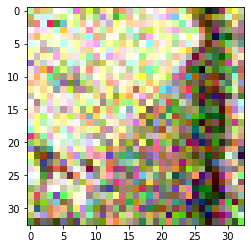

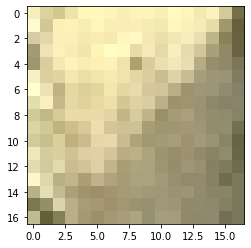

In [237]:
## test dataset 
# test_dataset = NoisyImageDataset("/content/test_data.csv",
                                #  "/content/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages")


# test_dataset = NoisyImageDataset("/content/test_data.csv",
#                                  "/content/original/")

test_dataset = NoisyImageDataset("/content/train_data.csv","/content/CBSD68-dataset-master/CBSD68")

sample = test_dataset[2]

plt.imshow(sample["noisy_image"].numpy().astype("uint8").transpose((1,2,0)))
plt.show()

plt.imshow(sample["original_image"].numpy().astype("uint8").transpose((1,2,0)))
plt.show()

real, noisy = sample["original_image"], sample["noisy_image"]

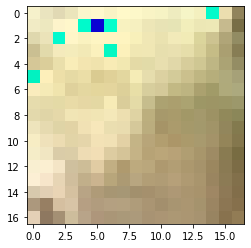

(17, 17, 3) (33, 33, 3)
(17, 17, 3) (17, 17, 3)
15.165599038905864 23.185159988493385
0.3191612901244631 0.7783553024364972


In [238]:
## PSNR calculations
denoised_img = model(noisy.cuda().unsqueeze(0)).cpu().squeeze().detach().numpy().transpose(1, 2, 0)

plt.imshow(denoised_img.astype("uint8"))
plt.show()

from skimage.measure import compare_psnr,compare_ssim

real = real.numpy().transpose(1, 2, 0)
noisy = noisy.numpy().transpose(1, 2, 0)
print(real.shape, noisy.shape)
h,w,_ = noisy.shape
noisy = noisy[8: h-8,8:w-8]
print(real.shape, noisy.shape)



real_psnr = compare_psnr(real,noisy ,255)
model_psnr = compare_psnr(real, denoised_img,255)

real_ssim = compare_ssim(X=real,Y=noisy ,data_range=255,multichannel=True)
model_ssim = compare_ssim(X=real,Y=denoised_img,data_range=255,multichannel=True)


print(real_psnr,model_psnr)
print(real_ssim,model_ssim)

In [156]:
## psnr stats

from tqdm import tqdm

psnrs = []
ssims = []

for sample in tqdm(test_dataset):
  real, noisy = sample["original_image"], sample["noisy_image"]
  ## PSNR calculations
  denoised_img = model(noisy.cuda().unsqueeze(0)).cpu().squeeze().detach().numpy().transpose(1, 2, 0)

  real = real.numpy().transpose(1, 2, 0)
  noisy = noisy.numpy().transpose(1, 2, 0)
  # print(real.shape, noisy.shape)
  h,w,_ = noisy.shape
  noisy = noisy[8: h-8,8:w-8]
  # print(real.shape, noisy.shape)



  real_psnr = compare_psnr(real,noisy ,255)
  model_psnr = compare_psnr(real, denoised_img,255)

  psnrs.append((real_psnr,model_psnr))

  real_ssim = compare_ssim(X=real,Y=noisy ,data_range=255,multichannel=True)
  model_ssim = compare_ssim(X=real,Y=denoised_img,data_range=255,multichannel=True)

  ssims.append((real_ssim,model_ssim))

100%|██████████| 67/67 [00:02<00:00, 29.05it/s]


In [157]:
s1 = [0,0]
s2 = [0,0]

for i in range(len(psnrs)):
  s1[0]+= psnrs[i][0]
  s1[1]+= psnrs[i][1]
  s2[0]+= ssims[i][0]
  s2[1]+= ssims[i][1]

n = len(psnrs)
print(n)

print(s1[0]/n,s1[1]/n)
print(s2[0]/n,s2[1]/n)


67
28.260697395304945 33.33608908764743
0.759813037313774 0.9310548294070953


In [0]:
## using dn_resnet 3 layer 

##psnr averages with 50 sigma, 200 crop size
14.973042415349417 25.678599595017495
0.25360402872293836 0.7169126150233502

##psnr averages with 25 sigma, 200 crop size
20.489541131226048 29.459506209247255
0.4543074518017813 0.8514222434602313

##psnr averages with 10 sigma, 200 crop size
28.260697395304945 33.33608908764743
0.759813037313774 0.9310548294070953

##psnr averages with 50 sigma, 33 crop size
15.047263794208707 26.689931811823588
0.22653035603369392 0.6985790887565936

In [0]:
## using dn_resnet 3 layer 

##psnr averages with 50 sigma, 200 crop size
14.936671462827626 25.587376709598537
0.24620526247389574 0.7081614024709503

##psnr averages with 25 sigma, 200 crop size
20.513676879788218 29.116933436963734
0.4654254023410544 0.8483339176769287

##psnr averages with 10 sigma, 200 crop size
28.25300504116213 32.842224416743036
0.7517520790173152 0.9220117575097961

##psnr averages with 50 sigma, 33 crop size
14.97794610257495 26.058241500922545
0.23024619624481021 0.7039497167777483

In [225]:
## save images

real_psnrs = []
model_psnrs = []
real_ssims = []
model_ssims = []
test_dataset = NoisyImageDataset("/content/test_data.csv","/content/CBSD68-dataset-master/CBSD68")

c = 0
for sample in tqdm(test_dataset):
  real, noisy = sample["original_image"], sample["noisy_image"]
  ## PSNR calculations
  denoised_img = model2(noisy.cuda().unsqueeze(0)).cpu().squeeze().detach().numpy().transpose(1, 2, 0)

  real = real.numpy().transpose(1, 2, 0)
  noisy = noisy.numpy().transpose(1, 2, 0)
  # print(real.shape, noisy.shape)
  h,w,_ = noisy.shape
  noisy = noisy[8: h-8,8:w-8]
  # print(real.shape, noisy.shape)
  real_psnr = compare_psnr(real,noisy ,255)
  model_psnr = compare_psnr(real, denoised_img,255)

  real_psnrs.append(real_psnr)
  model_psnrs.append(model_psnr)

  real_ssim = compare_ssim(X=real,Y=noisy ,data_range=255,multichannel=True)
  model_ssim = compare_ssim(X=real,Y=denoised_img,data_range=255,multichannel=True)

  real_ssims.append(real_ssim)
  model_ssims.append(model_ssim)
  
  denoised_img = denoised_img.astype("uint8")
  io.imsave('/content/drive/My Drive/dn_resnet_results/dn_resnet_150_fine_tuned/50/{}.jpg'.format(c), denoised_img)

  c+=1

df = pd.DataFrame({"r_p":real_psnrs,"m_p":model_psnrs,"r_s":real_ssims,"m_s":model_ssims})
df.to_csv("/content/drive/My Drive/dn_resnet_results/dn_resnet_150_fine_tuned/50/info.csv")

100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


In [0]:

## create 9 image plots for 10, 25 and 50 sigmas